#  Chest X-Ray Images Model and Predictions
 ## Project Overview
 This dataset contains thousands of validated OCT and Chest X-Ray images  described and analyzed in "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning". The images are split into a training set and a testing set of independent patients. Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

## Data Understanding
The dataset has been split into two main parts: a training set and a testing set. These sets consist of images from different patients, and they are used to train and evaluate deep learning algorithms for medical diagnosis.

Each image is labeled with information indicating the type of disease, a randomized patient ID, and a unique image number for that patient. This labeling system helps in organizing and identifying specific images within the dataset.

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus, causing cough with phlegm or pus, fever, chills, and difficulty breathing.Chest X-ray, may help confirm the diagnosis.

In [59]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  BatchNormalization, MaxPool2D
from keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2

## Dataset preparation
The dataset is organized into three folders, the train,test and validation which contain subfolders for each image category the Pneumonia and Normal.
The X-ray image category is  Pneumonia and Normal.

## Load the  Dataset.

In [60]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    images = []
    classes = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                classes.append(class_num)
            except Exception as e:
                print(f"Error processing image: {os.path.join(path, img)}")
                print(e)
    return np.array(images), np.array(classes)
# Load data
train, train_label = get_data('chest_xray/train')
test, test_label = get_data('chest_xray/test')
val, val_label = get_data('chest_xray/val')

In [67]:
print(train.shape)
print(test.shape)
print(val.shape)

(5216, 150, 150)
(624, 150, 150)
(16, 150, 150)


Checking out the dataset of two data points from data set.

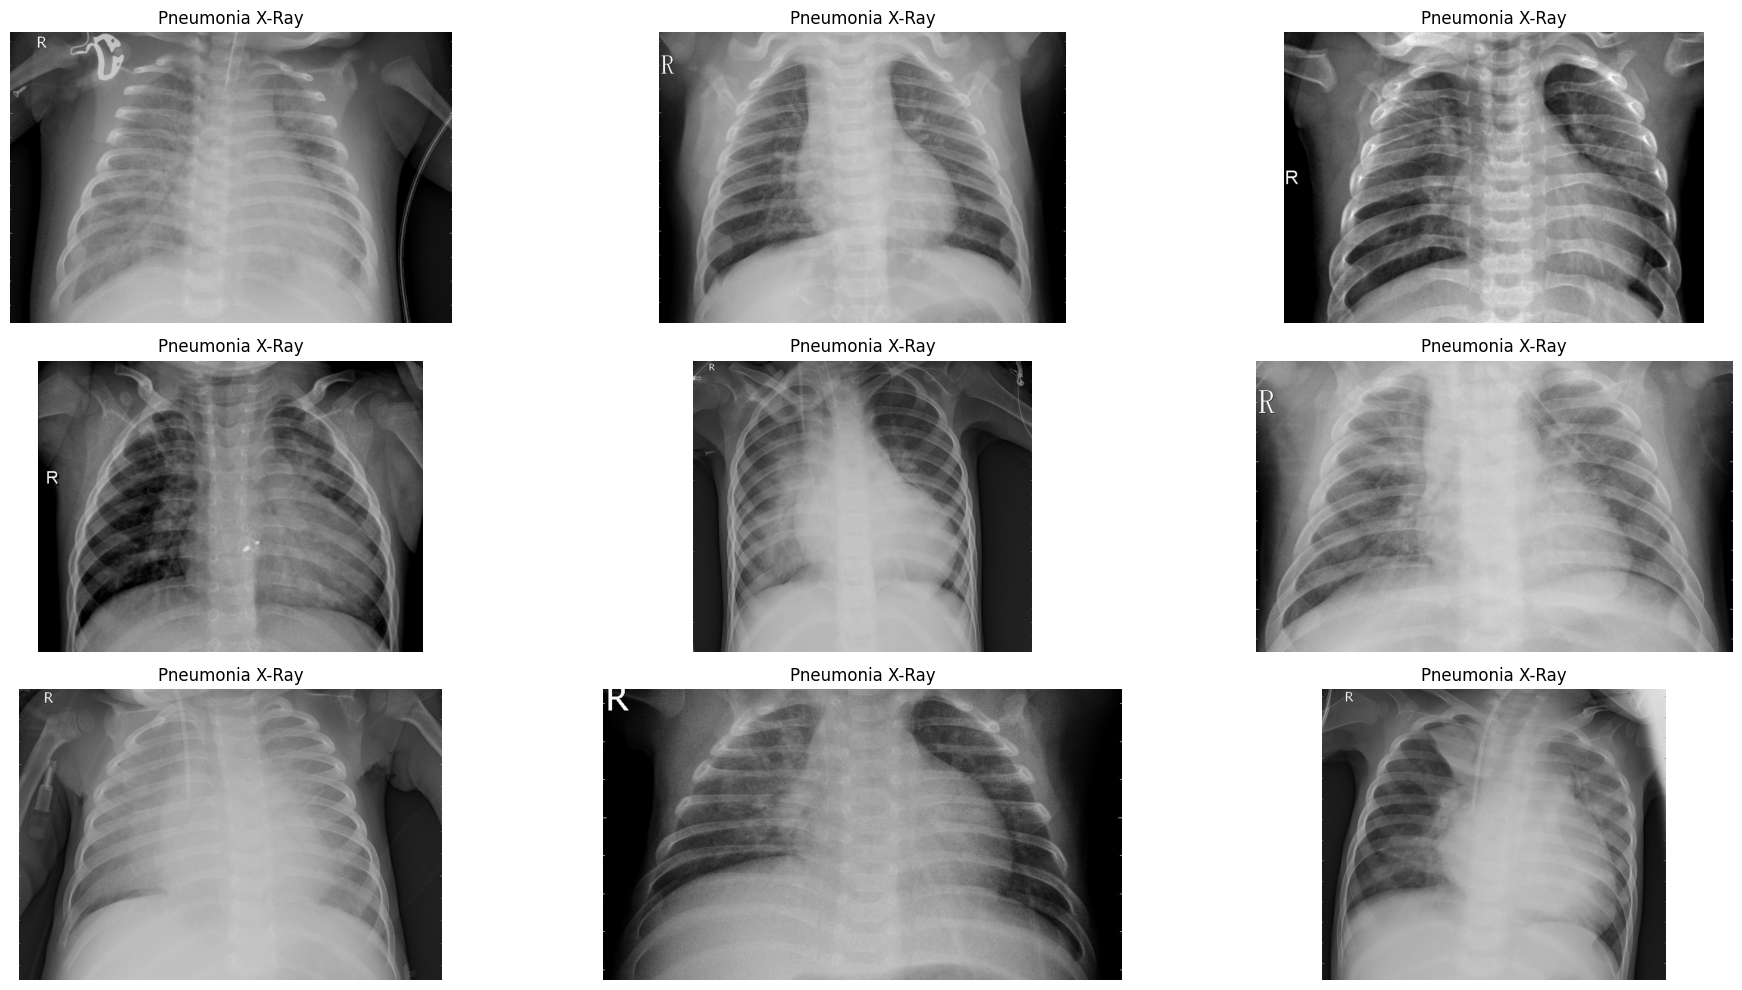

In [68]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray")
plt.tight_layout()

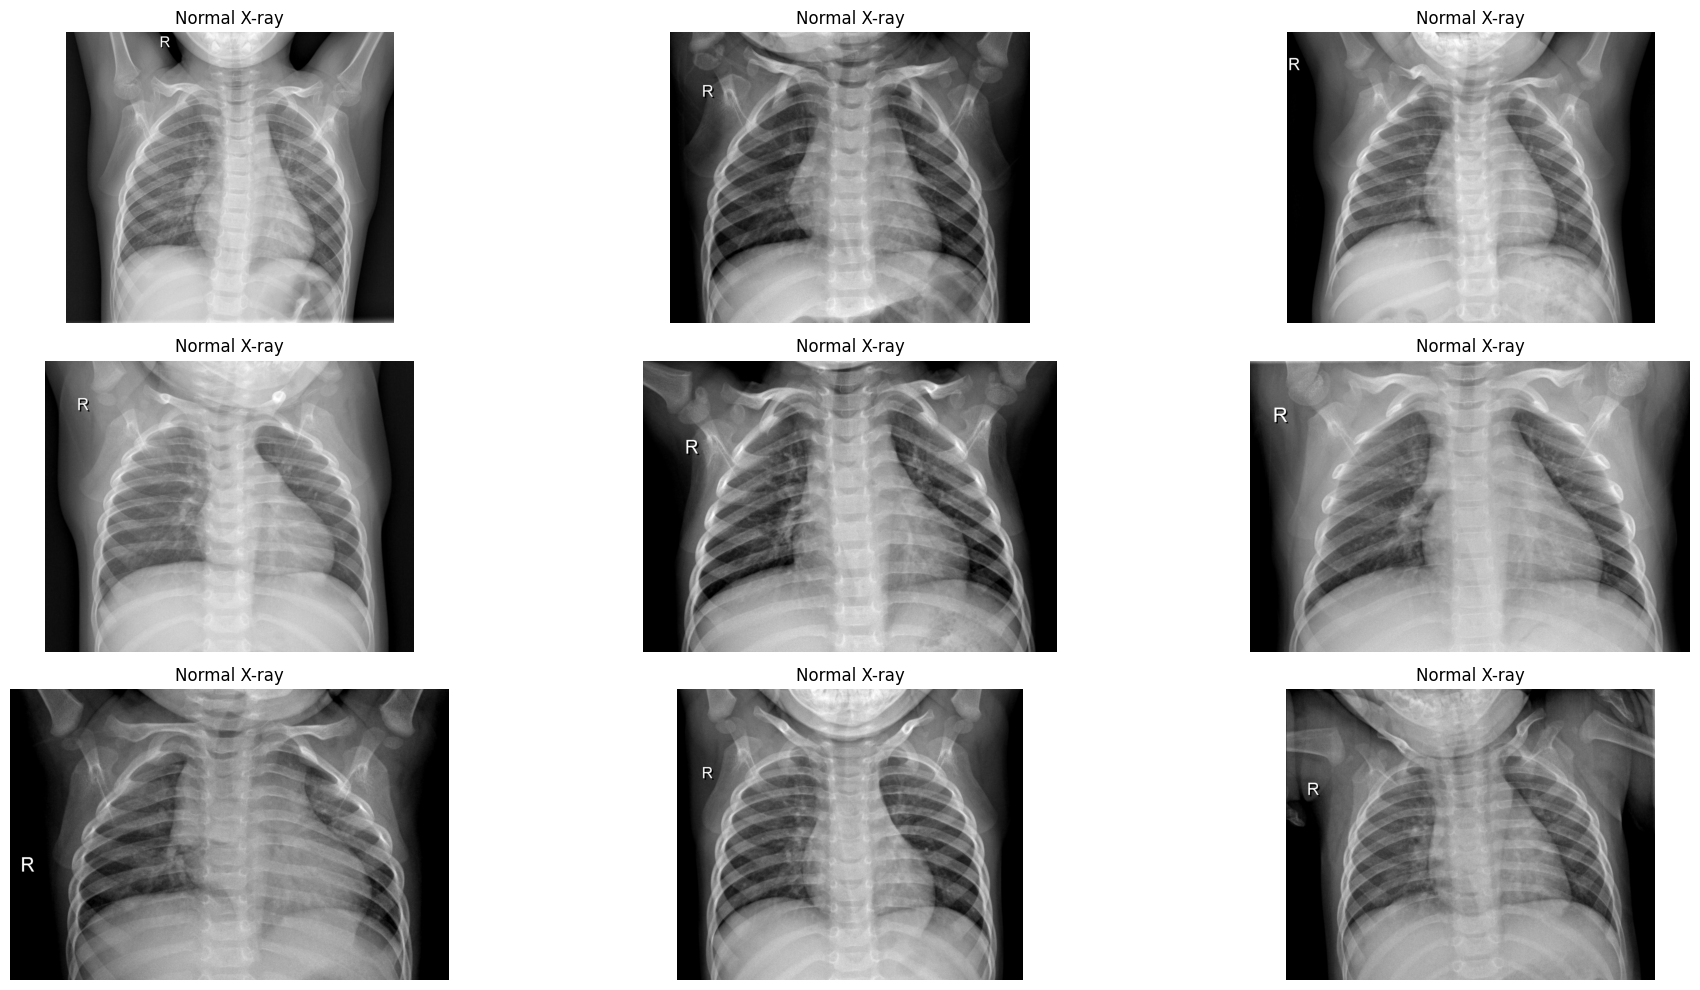

In [8]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i +1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Normal X-ray')

plt.tight_layout()

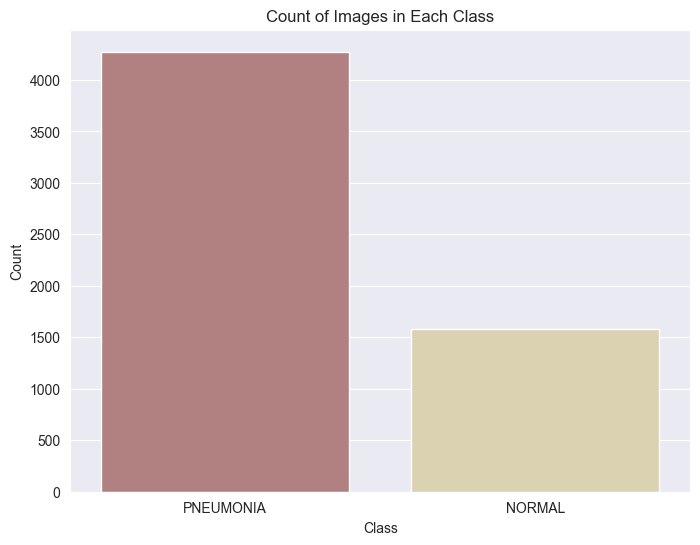

In [104]:
# Combine the labels and their corresponding datasets
all_labels = np.concatenate((train_label, test_label, val_label))

# Define label names
label_names = ['PNEUMONIA', 'NORMAL']

plt.figure(figsize=(8, 6))
sns.countplot(x=all_labels, palette='pink')
plt.title('Count of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=label_names)
plt.show()

Images of both the classes

Text(0.5, 1.0, 'NORMAL')

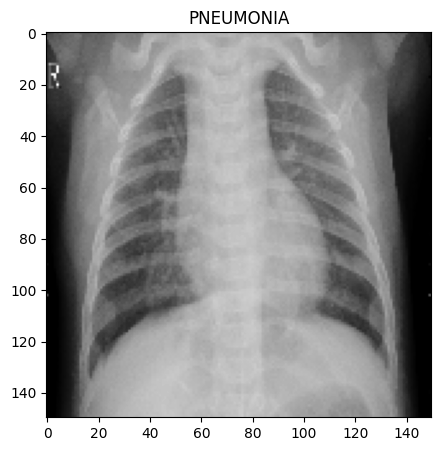

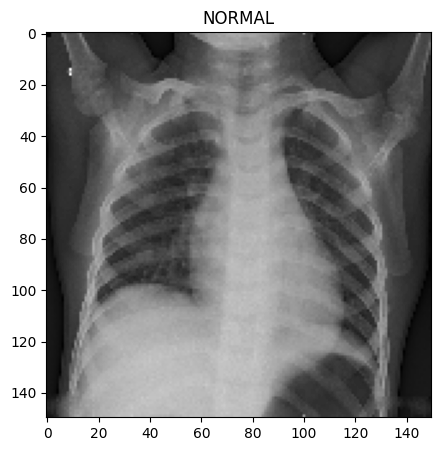

In [78]:
plt.figure(figsize=(5,5))
plt.imshow(train[1], cmap='gray')
plt.title(labels[train_label[1]])

plt.figure(figsize=(5,5))
plt.imshow(train[-1], cmap='gray')
plt.title(labels[train_label[-1]])

Normalization: Normalize the pixel values to be in the range of [0, 1]. This helps the model converge faster.

In [79]:
# # Normalize pixel values
train = train / 255.0
test = test / 255.0
val = val / 255.0

In [80]:
# Perform train-test split
train_images, val_images, train_labels, val_labels = train_test_split(train, train_label, test_size=0.2, random_state=42)

 Reshape Data
Ensure that the data is in the correct shape for model input. For CNNs, this typically means adding a channel dimension (for grayscale images) or making sure the channels are in the correct order (for RGB images).

In [82]:
# Reshape for CNN (add channel dimension)
train_images = train_images.reshape(-1, img_size, img_size, 1)
val_images = val_images.reshape(-1, img_size, img_size, 1)
test_images = test.reshape(-1, img_size, img_size, 1)

Data augmentation is a powerful technique to artificially increase the diversity of your training set. This can help prevent overfitting and improve the model's generalization.

In [83]:
# Initialize the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on your training data
datagen.fit(train_images)

## Modeling

In [84]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))

model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

Compiling the model with an optimizer, loss function, and metrics.

In [85]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 17, 17, 128)     

Using the augmented data generator to train the model.

In [87]:
# Train the model using the data generator
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                    epochs=10,
                    validation_data=(val_images, val_labels))

Epoch 1/10
131/131 [==============================] - 90s 658ms/step - loss: 0.4550 - accuracy: 0.7996 - val_loss: 0.6589 - val_accuracy: 0.7213
Epoch 2/10
131/131 [==============================] - 85s 649ms/step - loss: 0.3001 - accuracy: 0.8679 - val_loss: 0.3192 - val_accuracy: 0.8391
Epoch 3/10
131/131 [==============================] - 90s 685ms/step - loss: 0.2627 - accuracy: 0.8991 - val_loss: 0.4868 - val_accuracy: 0.7778
Epoch 4/10
131/131 [==============================] - 94s 719ms/step - loss: 0.2403 - accuracy: 0.9048 - val_loss: 0.3961 - val_accuracy: 0.7969
Epoch 5/10
131/131 [==============================] - 87s 664ms/step - loss: 0.2299 - accuracy: 0.9120 - val_loss: 0.5229 - val_accuracy: 0.7423
Epoch 6/10
131/131 [==============================] - 88s 671ms/step - loss: 0.2219 - accuracy: 0.9154 - val_loss: 1.3122 - val_accuracy: 0.7213
Epoch 7/10
131/131 [==============================] - 89s 676ms/step - loss: 0.2112 - accuracy: 0.9183 - val_loss: 0.9097 - val_ac

## Evaluating Model

In [88]:
test_loss, test_accuracy = model.evaluate(test_images, test_label)
print(f"Test Accuracy: {test_accuracy}")
test_loss, test_accuracy = model.evaluate(test_images, test_label)
print(f"Test Loss: {test_loss}")

20/20 [==============================] - 3s 156ms/step - loss: 0.4963 - accuracy: 0.8045
Test Accuracy: 0.8044871687889099
20/20 [==============================] - 3s 170ms/step - loss: 0.4963 - accuracy: 0.8045
Test Loss: 0.4962526559829712


## Visualizing Accuracy and Loss

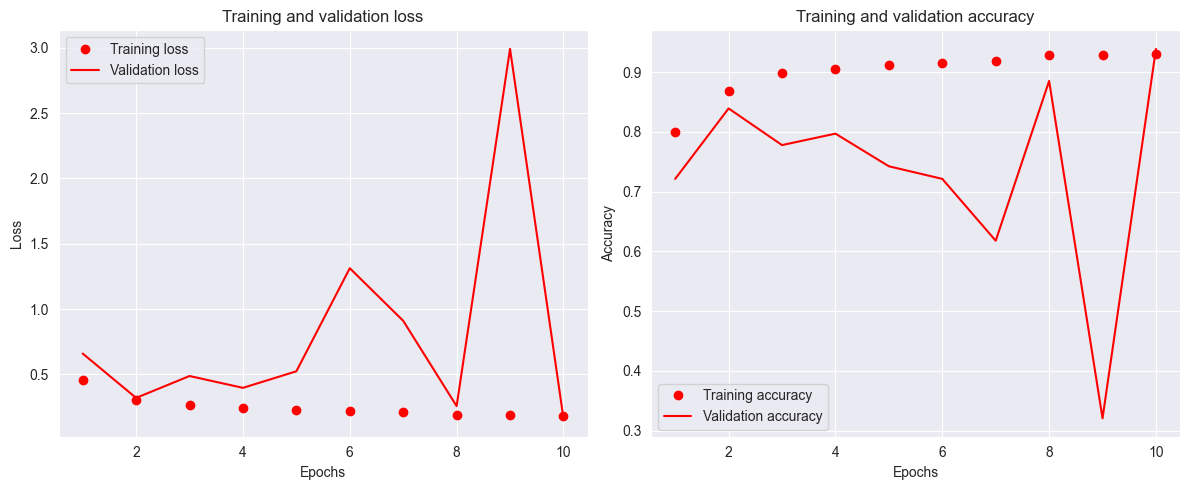

In [99]:
# Get the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## Predictions

In [105]:
predictions = model.predict(test_images)

20/20 [==============================] - 4s 163ms/step


In [106]:
# Convert probabilities to binary labels
binary_predictions = (predictions > 0.5).astype('int')

In [109]:
# Generate classification report
report = classification_report(test_label, binary_predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)'])

print(report)

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.76      0.99      0.86       390
   Normal (Class 1)       0.97      0.49      0.65       234

           accuracy                           0.80       624
          macro avg       0.87      0.74      0.76       624
       weighted avg       0.84      0.80      0.78       624



In [111]:
cm = confusion_matrix(test_label,binary_predictions)
cm

array([[387,   3],
       [119, 115]], dtype=int64)

In [112]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

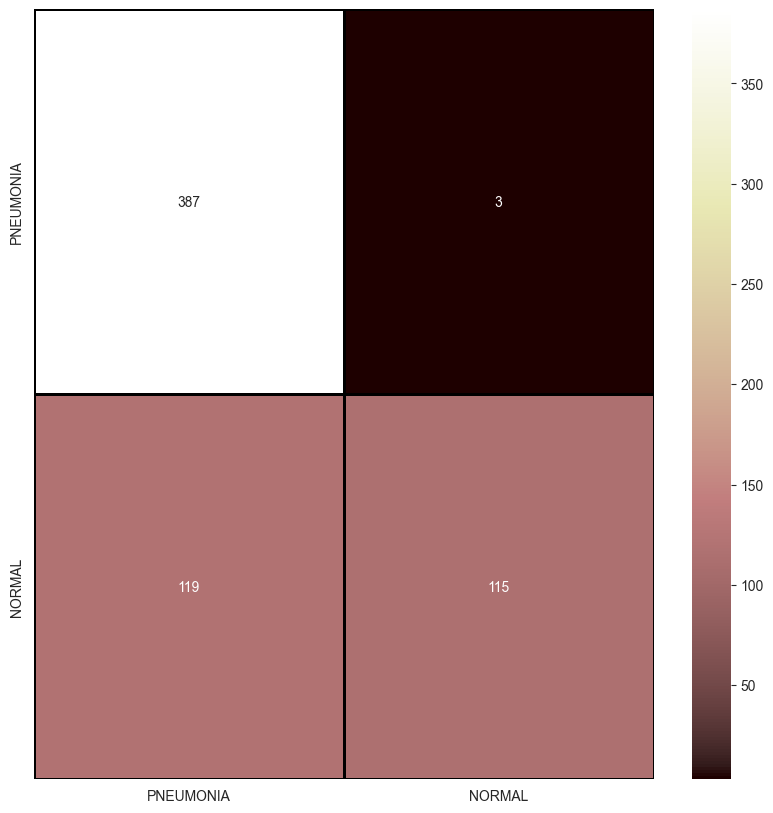

In [117]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "pink", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


The confusion matrix shows that the model is doing a good job of classifying pneumonia. The accuracy is high, and the sensitivity and specificity are also good.

In [118]:
model.save('model.h5')
